In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d, relu
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)


(9, 1, 1, 50, 50)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


(9, 1, 1, 3, 64)
(9, 1, 1, 64, 64)
(9, 1, 1, 64, 128)
(9, 1, 1, 128, 128)
(9, 1, 1, 128, 256)
(9, 1, 1, 256, 256)
(9, 1, 1, 256, 256)
(9, 1, 1, 256, 512)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


(9, 1, 1, 512, 512)
(9, 1, 1, 512, 512)
(9, 1, 1, 512, 512)
(9, 1, 1, 512, 512)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


(9, 1, 1, 512, 512)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


FileNotFoundError: [Errno 2] No such file or directory: 'figures/vgg16_dct.pdf'

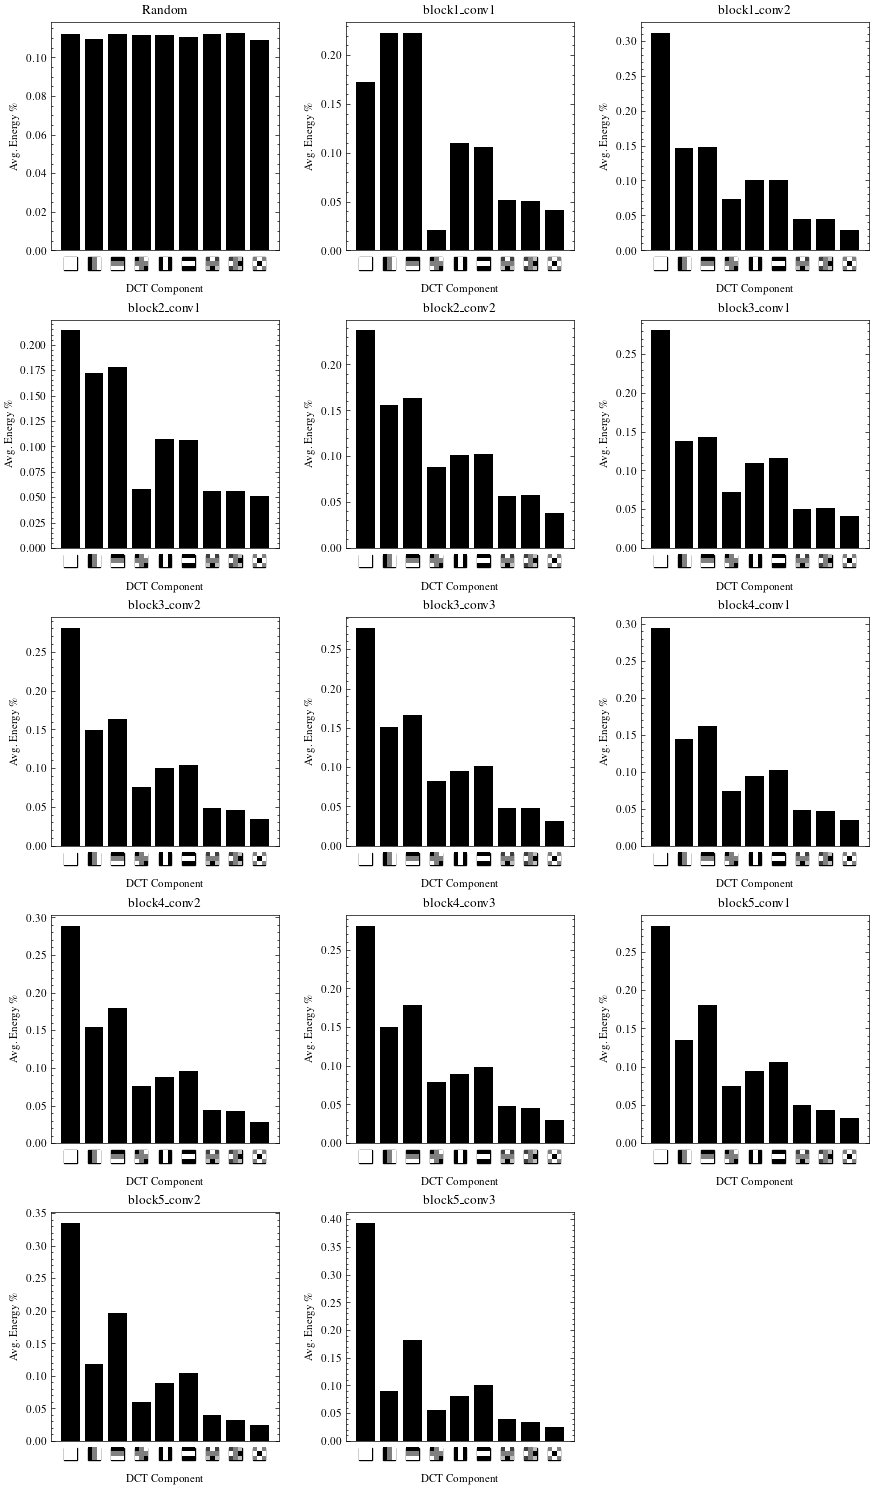

In [4]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


#bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0) , (0,1), (1,0), (1,1), (0, 2) , (2, 0), (1,2), (2,1), (2,2) ]

d = []
for  i,j in pos:
	t = np.zeros((3,3))
	t[i,j] =1
	d.append(tf.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)))
d = tf.cast(tf.stack(d), dtype=tf.float32)

fig,axs= plt.subplots(nrows=5, ncols=3,figsize=(9, 15))
axs = axs.ravel()

for l_num in range(-1, 13):
	
	if l_num == -1:
		f = np.random.normal(0,1, size=(3,3,50,50))
		title = "Random"
	else:
		f = get_filter(model, l_num)
		title = conv_layers[l_num].name
	w = tf.reshape(tf.reduce_sum(f*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	print(w.shape)
	bars =  axs[l_num+1].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], tf.reduce_sum(tf.abs(w), axis=(1,2,3,4))/tf.math.reduce_sum(tf.abs(w)))


	for i, bar in enumerate(bars):
		# Load image

		dct_im = np.zeros((3,3))
		dct_im[pos[i]]=1
		#print(idct2(np.float16(dct_im)))
		img = idct2(np.float16(dct_im))

		# Create OffsetImage object
		im = OffsetImage(img, zoom=3, cmap=plt.cm.binary)  # Adjust zoom for image size

		# Get the x position of the bar's center
		x_position = bar.get_x() + bar.get_width() / 2

		# Place image below the x-axis label
		ab = AnnotationBbox(im, (x_position, 0), 
							xybox=(0, -5),  # Adjust the second value for distance under the label
							xycoords='data', 
							boxcoords="offset points", 
							pad=0, frameon=True, 
							box_alignment=(0.5, 1))

		# Add image to the axes
		axs[l_num+1].add_artist(ab)
	axs[l_num+1].set_xticklabels([''] * w.shape[0])  # Set empty labels
	axs[l_num+1].set_xlabel('DCT Component')
	axs[l_num+1].xaxis.set_label_coords(0.5, -0.15)
	axs[l_num+1].set_ylabel('Avg. Energy \%')
	axs[l_num+1].set_box_aspect(1)
	axs[l_num+1].set_title(title)


	axs[l_num+1].tick_params(axis='x', which='both', length=0)
axs[-1].set_box_aspect(1)

fig.delaxes(axs[-1])

fig.tight_layout()
plt.savefig('figures/vgg16_dct.pdf', dpi=600)

plt.show()